# Visibilities with 3 holes
With three holes we have 3 baselines and the images become harder to interpret, though in reality they are just the superposition of three of the sine waves seen for a single baseline, each of which is at a different angle and with a different wavelength. Fitting three sets of fringes is impractical, so Fourier transforming the image to get the visibilities is therefore the best option.

The example here is the same as in the lab; three holes, with two baselines at right angles and one twice as long as the other.

In [1]:
# if you get package errors you may need to uncomment and run this
# !pip install astropy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# uncomment to make plots interactive
# %matplotlib notebook

## First estimate what the image will look like
We do this by setting up the apertures, then FTing and taking the absolute value to get the image we will get, and then take the FT of that to get the visibilities.

In [3]:
# set the image size to use below
nxy = 512

In [4]:
# function to add a 2d Gaussian somewhere in an image
def gauss(sigma, peak=1, xoff=0, yoff=0):
    xc = nxy/2 + xoff
    yc = nxy/2 + yoff
    x = np.arange(nxy) - xc
    y = np.arange(nxy) - yc
    xx, yy = np.meshgrid(x, y)
    r = np.sqrt( xx**2 + yy**2 )
    return peak * np.exp(-0.5 * (r/sigma)**2)

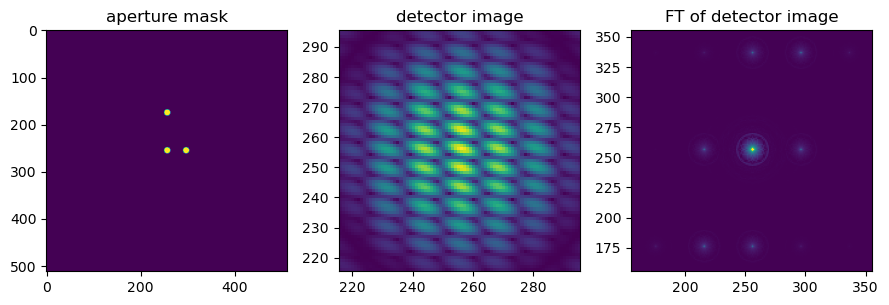

In [5]:
width = 3.

im =  gauss(width, peak=1)
im += gauss(width, xoff=40, peak=1)
im += gauss(width, yoff=-80, peak=1)
ok = im > 0.1
im[ok] = 1
im[np.invert(ok)] = 0

ft = np.fft.fftshift(np.fft.fft2(im))
ft = np.abs(ft)

im2 = np.fft.fftshift(np.fft.fft2(ft))
im2 /= np.max(im2)

fig, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].imshow(np.abs(im))
ax[1].imshow(np.abs(ft))
ax[2].imshow(np.abs(im2), vmax=0.5)

ax[0].set_title('aperture mask')
ax[1].set_title('detector image')
ax[2].set_title('FT of detector image')

# # zoom the second FT
cx = (ft.shape[1]-1) / 2
cy = (ft.shape[0]-1) / 2
n = 50 #np.max([np.abs(mxy[0]-cy), np.abs(mxy[1]-cx)])
ax[2].set_xlim(cx-2*n,cx+2*n)
ax[2].set_ylim(cy-2*n,cy+2*n)

n=20
ax[1].set_xlim(cx-2*n,cx+2*n)
ax[1].set_ylim(cy-2*n,cy+2*n)

fig.tight_layout()

# Real data
An example of reading a FITS file and plotting the Fourier transform

In [6]:
im = fits.getdata('../testdata/3h/2023-02-02-1532_5-U-G-Jup_0002.fits') # b
im = fits.getdata('../testdata/3h/2023-02-02-1536_4-U-G-Jup_0000.fits') # g
im = fits.getdata('../testdata/3h/2023-02-02-1537_7-U-G-Jup_0001.fits') # r

# select an image to plot
im = im - np.percentile(im.astype(float), 20)

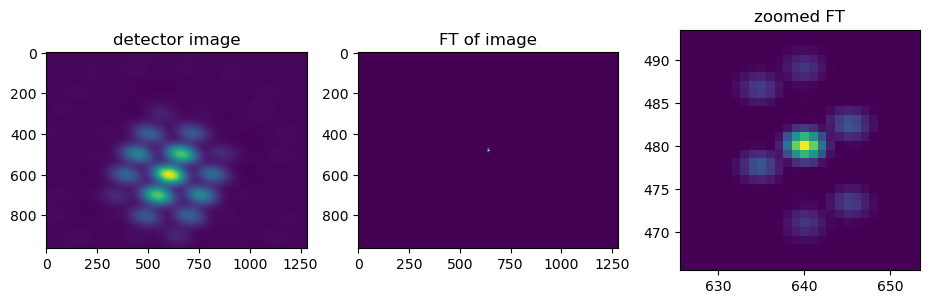

In [7]:
ft = np.fft.fftshift(np.fft.fft2(im))
ft = np.abs(ft)
ft /= np.max(ft)

fig, ax = plt.subplots(1, 3, figsize=(9.5,3))
ax[0].imshow(im)
ax[1].imshow(ft, vmin=0, vmax=0.2)
ax[2].imshow(ft, vmin=0, vmax=1)

ax[0].set_title('detector image')
ax[1].set_title('FT of image')
ax[2].set_title('zoomed FT')

# zoom the second FT
cx = (ft.shape[1]-1) / 2
cy = (ft.shape[0]-1) / 2
n = 7 #np.max([np.abs(mxy[0]-cy), np.abs(mxy[1]-cx)])
ax[2].set_xlim(cx-2*n,cx+2*n)
ax[2].set_ylim(cy-2*n,cy+2*n)

fig.tight_layout()

Here we have the image at left, the FT in the middle, and a zoomed version of the FT at the right. The FT has three pairs of peaks that are on opposite sides of the central peak, plus the PSF peak in the center. Each pair of peaks corresponds to a baseline, and we can figure out which is which by knowing that the shortest baseline corresponds to the lowest frequency, which is closer to the center of the FT.

To get visiblities, we take one value for each pair of peaks (the values will be identical), and multiply those values by three (as we have 3 holes). We then assign each of these to a baseline and wavelength to get the $b/\lambda$ value, which we can then fit a visibility curve to as for two holes.

In [8]:
# shortest to longest (0.5, 1, 1.1)
v_r = np.array([0.270, 0.186, 0.161]) * 3
v_g = np.array([0.282, 0.220, 0.199]) * 3
v_b = np.array([0.304, 0.262, 0.219]) * 3

In [9]:
# b / lambda
lam = np.array([615, 530, 455]) * 1e-9
r = np.array([0.5, 1, np.sqrt(0.5*0.5+1)])*1e-3
u_r = r / lam[2]
u_g = r / lam[1]
u_b = r / lam[0]

In [10]:
# full visibility lists as used in the visibility notebook
v_all = np.concatenate((v_r,v_g,v_b))
u_all = np.concatenate((u_r,u_g,u_b))

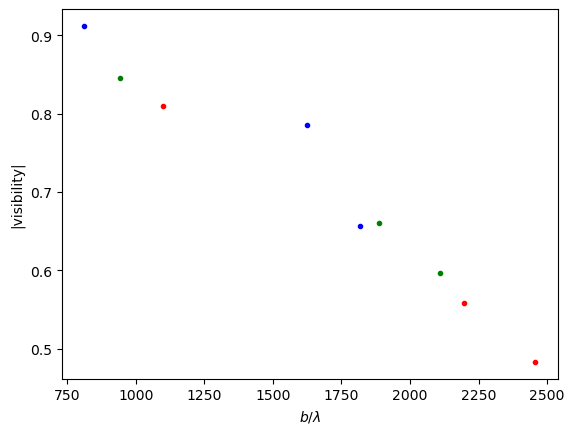

In [11]:
fig, ax = plt.subplots(1, sharex=True)
ax.plot(u_r, v_r, '.r')
ax.plot(u_g, v_g, '.g')
ax.plot(u_b, v_b, '.b')
ax.set_xlabel('$b/\\lambda$')
ax.set_ylabel('|visibility|')
fig.subplots_adjust(hspace=0.1)

These values can be copied across to the visibility notebook and the fitting re-run to estimate the aperture size.